# Validate XG Boost Data

---

* Objective: 
  * Do we need to filter out any records from response data?

---
* __author__: Eric 
* __credits__: Michael & Jude
* __status__: Development

In [1]:
#packages

import pandas as pd
import numpy as np
import matplotlib as plt
import warnings
import sqlite3

# hide warnings
warnings.filterwarnings('ignore')

In [2]:
# improvement from earlier process and use code Jude wrote to connect to v4 data


def create_connection(path):
    connection = None 
    connection = sqlite3.connect(path)
    connection.text_factory = str

    return connection

In [3]:

##Update this, its probably not where your DB is
con = create_connection('/Users/ericfitchwell/Downloads/fire_data_v4.db')

In [4]:

cur = con.cursor()

# remove join from fire incidents, add fields to get more info about incident
df = pd.read_sql('''

select calls_for_service.call_number 
        , calls_for_service.incident_number 
        , calls_for_service.call_type
        , floating_catchment_output.[index] 
        , floating_catchment_output.zone_idx 
        , floating_catchment_output.accessibility_score 
        , floating_catchment_output.scenario_name 
        , calls_for_service.on_scene_dttm 
        , calls_for_service.response_dttm   
        , calls_for_service.zipcode_of_incident       
        from floating_catchment_output
        inner join zone_idx_to_incident on  
        zone_idx_to_incident.zone_idx = floating_catchment_output.zone_idx 
        inner join calls_for_service on calls_for_service.incident_number = zone_idx_to_incident.incident_number 
        where calls_for_service.unit_type in ('TRUCK', 'ENGINE') 
        and scenario_name = 'baseline'



''',con = con)

In [5]:
#info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137425 entries, 0 to 137424
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   call_number          137425 non-null  int64  
 1   incident_number      137425 non-null  int64  
 2   call_type            137425 non-null  object 
 3   index                137425 non-null  int64  
 4   zone_idx             137425 non-null  int64  
 5   accessibility_score  137425 non-null  float64
 6   scenario_name        137425 non-null  object 
 7   on_scene_dttm        110681 non-null  object 
 8   response_dttm        134234 non-null  object 
 9   zipcode_of_incident  137425 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 10.5+ MB


In [6]:
df1 = df.groupby('call_type')['incident_number'].count().reset_index()

df1['percent'] = 100 * df1['incident_number']  / df1['incident_number'].sum()

df1.sort_values(by=['percent'],ascending=False)

,call_type,incident_number,percent
15,Medical Incident,73790,53.694743
1,Alarms,25557,18.597053
21,Structure Fire,15523,11.295616
23,Traffic Collision,5593,4.069856
3,Citizen Assist / Service Call,3718,2.705476
19,Outside Fire,3565,2.594142
18,Other,2548,1.854102
5,Electrical Hazard,1580,1.149718
10,Gas Leak (Natural and LP Gases),1331,0.968528
6,Elevator / Escalator Rescue,1079,0.785156


In [7]:
#missing values in data
total = np.product(df.shape)
missing = df.isnull().sum()
total_missing = missing.sum()

print("Fire data missing", round(((total_missing/total) * 100), 2), "%", "missing values.")

Fire data missing 2.18 % missing values.


In [8]:
df3 = pd.read_sql('''select  
        incident_number
            
            
        from fire_incidents 

        where incident_date between '2019-01-01' and '2020-01-01'
         
        ''',
        con=con)

In [9]:
fire_incidents = df3['incident_number'].tolist()

print(len(fire_incidents))

33106


In [10]:
df4 = df[df['incident_number'].isin(fire_incidents)]

fire_source = len(df4['incident_number'])
incident_source = len(df['incident_number'])

print("Percentage of fires in incident data", round(((fire_source/incident_source)\
                                                                * 100), 2), "%")

Percentage of fires in incident data 43.65 %


In [11]:
df5 = df4.groupby('incident_number')['call_number'].count().reset_index(name='volume').sort_values(by='volume',\
 ascending=False)

In [12]:
df5

,incident_number,volume
28422,19138172,28
3293,19015528,27
24633,19120353,16
23489,19115105,16
17421,19086029,13
...,...,...
20976,19103227,1
20977,19103229,1
7658,19037120,1
7657,19037114,1


array([[<AxesSubplot:title={'center':'incident_number'}>,
        <AxesSubplot:title={'center':'volume'}>]], dtype=object)

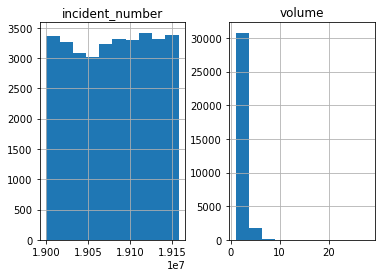

In [13]:
df5.hist()